## Import Library

Install opendatasets yaitu library untuk mendownload dataset

In [3]:
!pip install opendatasets

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import opendatasets as od

from nltk.tokenize import word_tokenize
from pathlib import Path
from zipfile import ZipFile

from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Concatenate, Input

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Data Understanding

1.Download dataset yang dibutuhkan yaitu **Movie Recommendation Data** yang didapat dari situs **Kaggle**, dari tautan berikut [movie-recommendation-data](https://www.kaggle.com/rohan4050/movie-recommendation-data), dengan menambah baris code seperti berikut, memasukkan username dan account number akun kaggle :

In [6]:
od.download('https://www.kaggle.com/rohan4050/movie-recommendation-data?select=ml-latest-small')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: evlinsitanggang
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rohan4050/movie-recommendation-data


100%|██████████| 13.1M/13.1M [00:01<00:00, 10.4MB/s]


2.Selanjutnya, baca dan proses data-data yang sudah di download dengan menggunakan fungsi **pd.read_csv**

In [7]:
ratings = pd.read_csv('/content/movie-recommendation-data/ml-latest-small/ratings.csv')
movies = pd.read_csv('/content/movie-recommendation-data/ml-latest-small/movies.csv')
links = pd.read_csv('/content/movie-recommendation-data/ml-latest-small/links.csv')
tags = pd.read_csv('/content/movie-recommendation-data/ml-latest-small/tags.csv')

print('Jumlah data ratings dari user : ', len(ratings.userId.unique()))
print('Jumlah data ratings untuk movie : ', len(ratings.movieId.unique()))
print('Jumlah data movie : ', len(movies.movieId.unique()))
print('Jumlah data link movie : ', len(links.movieId.unique()))
print('Jumlah data : ', len(tags.movieId.unique()))

Jumlah data ratings dari user :  610
Jumlah data ratings untuk movie :  9724
Jumlah data movie :  9742
Jumlah data link movie :  9742
Jumlah data :  1572


3.Dataset Link

Melakukan eksplorasi variabel links, merupakan daftar link movie tersebut.

3.1 Melihat informasi variabel dalam dataset link

In [8]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


4.Dataset Movies

Melakukan eksplorasi variabel movies yang merupakan daftar movie yang tersedia.

4.1 Melihat informasi variabel dalam dataset movie

In [32]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


5.Dataset Tags

Melakukan eksplorasi variabel tags yang merupakan daftar tags (tagar) yang tersedia.

5.1 Melihat informasi variabel dalam dataset tags

In [31]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


6.Dataset Ratings

Melakukan eksplorasi data yang akan digunakan pada model yaitu data ratings.

6.1 Melihat informasi variabel dalam dataset Ratings

In [32]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


7.Melakukan pengecekan nilai data dari data ratings

In [17]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Dari output di atas, diketahui bahwa nilai maksimum ratings adalah 5.0 atau 5 dan nilai minimumnya adalah 0.5. Artinya, skala rating berkisar antara 0.5 hingga 5.

## Data Preprocessing


1.Menggabungkan Movie

Menggabungkan data dari file berbeda (links, movies, ratings, tags) menggunakan pd.merge().




In [18]:
movie_all = np.concatenate((
    links.movieId.unique(),
    movies.movieId.unique(),
    ratings.movieId.unique(),
    tags.movieId.unique(),
))

movie_all = np.sort(np.unique(movie_all))

print('Jumlah seluruh data movie berdasarkan movieID: ', len(movie_all))

Jumlah seluruh data movie berdasarkan movieID:  9742


2.Menggabungkan Seluruh User

Menggabungkan beberapa file dengan fungsi concatenate berdasarkan pada userId, gabungkan seluruh data pada variabel user_all

In [19]:
user_all = np.concatenate((
    ratings.userId.unique(),
    tags.userId.unique()))

user_all = np.sort(np.unique(user_all))

print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  610


3.Menggabungkan file links, movies, ratingsm tags ke dalam dataframe movie_info. Serta menggabungkan dataframe ratings dengan movie_info berdasarkan nilai movieId

In [20]:
movie_info = pd.concat([links, movies, ratings, tags])
movie = pd.merge(ratings, movie_info , on='movieId', how='left')
movie

,userId_x,movieId,rating_x,timestamp_x,imdbId,tmdbId,title,genres,userId_y,rating_y,timestamp_y,tag
0,1,1,4.0,964982703,114709.0,862.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,4.0,964982703,NaN,NaN,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,NaN,NaN
2,1,1,4.0,964982703,NaN,NaN,NaN,NaN,1.0,4.0,9.649827e+08,NaN
3,1,1,4.0,964982703,NaN,NaN,NaN,NaN,5.0,4.0,8.474350e+08,NaN
4,1,1,4.0,964982703,NaN,NaN,NaN,NaN,7.0,4.5,1.106636e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6359580,610,170875,3.0,1493846415,4630562.0,337339.0,NaN,NaN,NaN,NaN,NaN,NaN
6359581,610,170875,3.0,1493846415,NaN,NaN,The Fate of the Furious (2017),Action|Crime|Drama|Thriller,NaN,NaN,NaN,NaN
6359582,610,170875,3.0,1493846415,NaN,NaN,NaN,NaN,50.0,1.0,1.514498e+09,NaN
6359583,610,170875,3.0,1493846415,NaN,NaN,NaN,NaN,249.0,3.0,1.505165e+09,NaN


4.Seperti yang dilihat dari hasil diatas terdapat banyak sekali missing value maka lakukan cek missing value.


In [21]:
movie.isnull().sum()

,0
userId_x,0
movieId,0
rating_x,0
timestamp_x,0
imdbId,6258749
tmdbId,6258762
title,6258749
genres,6258749
userId_y,201672
rating_y,434885


5.Kemudian melakukan penggabungan rating berdasarkan movieId

In [22]:
movie.groupby('movieId').sum()

,userId_x,rating_x,timestamp_x,imdbId,tmdbId,title,genres,userId_y,rating_y,timestamp_y,tag
movieId,,,,,,,,,,,
1,14498880,185460.0,53441180205380,24662435.0,185330.0,Toy Story (1995)Toy Story (1995)Toy Story (199...,Adventure|Animation|Children|Comedy|FantasyAdv...,14465415.0,181245.0,5.304394e+13,pixarpixarfunpixarpixarfunpixarpixarfunpixarpi...
2,4205116,43790.0,14492875665352,12484670.0,972840.0,Jumanji (1995)Jumanji (1995)Jumanji (1995)Juma...,Adventure|Children|FantasyAdventure|Children|F...,4060210.0,41525.0,1.437287e+13,fantasymagic board gameRobin Williamsgamefanta...
3,825832,9492.0,2926881125616,5887856.0,811304.0,Grumpier Old Men (1995)Grumpier Old Men (1995)...,Comedy|RomanceComedy|RomanceComedy|RomanceCome...,796900.0,8814.0,2.836734e+12,moldyoldmoldyoldmoldyoldmoldyoldmoldyoldmoldyo...
4,13851,148.5,56610468432,804195.0,219499.0,Waiting to Exhale (1995)Waiting to Exhale (199...,Comedy|Drama|RomanceComedy|Drama|RomanceComedy...,10773.0,115.5,4.403036e+10,0
5,777987,7976.5,2577949287482,5539009.0,581238.0,Father of the Bride Part II (1995)Father of th...,ComedyComedyComedyComedyComedyComedyComedyCome...,765723.0,7374.5,2.494850e+12,pregnancyremakepregnancyremakepregnancyremakep...
...,...,...,...,...,...,...,...,...,...,...,...
193581,552,12.0,4611327246,5476944.0,432131.0,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09,0
193583,552,10.5,4611328635,5914996.0,445030.0,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09,0
193585,552,10.5,4611329415,6397426.0,479308.0,Flint (2017),Drama,184.0,3.5,1.537110e+09,0


6.Menggabungkan Data dengan Fitur Nama Movie

Mendefinisikan variabel all_movie_rate dengan variabel ratings

In [23]:
all_movie_rate = ratings
all_movie_rate

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


7.Menggabungkan all movie_rate dengan dataframe movies berdasarkan movieId

In [24]:
all_movie_name = pd.merge(all_movie_rate, movies[['movieId','title','genres']], on='movieId', how='left')
all_movie_name

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


8.Menggabungkan dataframe tags dengan all_movie_name berdasarkan movieId dan memasukkannya ke dalam variabel all_movie

In [25]:
all_movie = pd.merge(all_movie_name, tags[['movieId','tag']], on='movieId', how='left')
all_movie

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
...,...,...,...,...,...,...,...
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,emotional
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,gritty
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,heartbreaking
285760,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,predictible plot


## Data Preparation


1.Mengatasi Missing Value

Mencari data apakah ada data kosong atau tidak

In [26]:
all_movie.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0
tag,52549


2.Ternyata dari data diatas terdapat data kosong pada kolom tag yaitu 52549, maka dilakukanlah pembersihan missing value dengan fungsi dropna()

In [27]:
all_movie_clean = all_movie.dropna()
all_movie_clean

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
...,...,...,...,...,...,...,...
285756,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,dark
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,emotional
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,gritty
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,heartbreaking


3.Data di atas beruabh menjadi 233213 baris yang awalnya 285762 baris.
Lalu periksa kembali missing value pada variabel all_movie_clean


In [28]:
all_movie_clean.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0
tag,0


4.Mengurutkan movie berdasarkan movieId kemudian memasukkannya ke dalam variabel fix_movie

In [29]:
fix_movie = all_movie_clean.sort_values('movieId', ascending=True)
fix_movie

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121430,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121431,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121432,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
35190,73,1,4.5,1464196374,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
...,...,...,...,...,...,...,...
263644,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars
81531,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime
81532,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy
81534,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster


5.Mengecek berapa jumlah fix_movie

In [48]:
len(fix_movie.movieId.unique())

1554

6.Membuat variabel preparation yang berisi dataframe fix_movie kemudian mengurutkan berdasarkan movieId

In [49]:
preparation = fix_movie
preparation.sort_values('movieId')

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
44427,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
44426,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
44425,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
209733,453,1,5.0,1005966797,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
...,...,...,...,...,...,...,...
191470,414,187595,3.5,1527977920,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars
81534,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster
81531,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime
81532,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy


7.Selanjutnya, gunakan data unik untuk dimasukkan ke dalam proses pemodelan.
serta hapus data duplicate dengan fungsi drop_duplicates() berdasarkan movieId

In [50]:
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
187260,414,2,3.0,961594981,Jumanji (1995),Adventure|Children|Fantasy,fantasy
106951,240,3,4.0,849122858,Grumpier Old Men (1995),Comedy|Romance,old
19921,45,5,3.0,959625102,Father of the Bride Part II (1995),Comedy,pregnancy
115692,262,7,3.0,840306238,Sabrina (1995),Comedy|Romance,remake
...,...,...,...,...,...,...,...
27632,62,183611,4.0,1526244681,Game Night (2018),Action|Comedy|Crime|Horror,Comedy
174264,380,184471,3.0,1536872748,Tomb Raider (2018),Action|Adventure|Fantasy,Alicia Vikander
44721,98,187593,5.0,1532457913,Deadpool 2 (2018),Action|Comedy|Sci-Fi,sarcasm
263643,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,Emilia Clarke


8.Selanjutnya,  melakukan konversi data series menjadi list. Dalam hal ini, menggunakan fungsi tolist() dari library numpy. Implementasikan

In [51]:
movie_id = preparation['movieId'].tolist()
movie_name = preparation['title'].tolist()
movie_genre = preparation['genres'].tolist()

print(len(movie_id))
print(len(movie_name))
print(len(movie_genre))

1554
1554
1554


9.Membuat dictionary untuk menentukan pasangan key-value pada data movie_id, movie_name, dan movie_genre yang telah disiapkan sebelumnya.

In [52]:
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_name': movie_name,
    'genre': movie_genre
})
movie_new

,id,movie_name,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,5,Father of the Bride Part II (1995),Comedy
4,7,Sabrina (1995),Comedy|Romance
...,...,...,...
1549,183611,Game Night (2018),Action|Comedy|Crime|Horror
1550,184471,Tomb Raider (2018),Action|Adventure|Fantasy
1551,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi
1552,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi


## Modeling and Result

Proses modeling yang dilakukan adalah dengan algoritma machine learning, yaitu **content based filtering** dan **collabrative filtering**. untuk algoritma content based filtering saya buat dengan apa yang disukai pengguna pada masa lalu, sedangkan untuk content based filtering, saya buat dengan memanfaatkan tingkat rating dari movie tersebut.



### **1. Content Based Filtering**

**TF-IDF Vectorizer**:

1.Genre setiap film diubah menjadi vektor numerik menggunakan TfidfVectorizer.
Menghasilkan matriks tf-idf untuk menghitung relevansi antar film.

In [55]:
tf = TfidfVectorizer()
tf.fit(movie_new['genre'])
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

2.Selanjutnya, lakukan fit dan transformasi ke dalam bentuk matriks.

In [56]:
tfidf_matrix = tf.fit_transform(movie_new['genre'])
tfidf_matrix.shape

(1554, 24)

  3.Menghasilkan vektor tf-idf dalam bentuk matriks, menggunakan fungsi todense().

In [57]:
tfidf_matrix.todense()

matrix([[0.        , 0.3983147 , 0.52247057, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.49497089, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.49413097, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.39639614, 0.40792706, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.41107716, 0.        , 0.55489644, ..., 0.        , 0.        ,
         0.        ]])

4.Lihat matriks tf-idf untuk beberapa movie (movie_name) dan genre

In [59]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=movie_new.movie_name
).sample(22, axis=1).sample(10, axis=0)

,film,genres,adventure,no,imax,romance,drama,noir,crime,fi,...,thriller,listed,sci,fantasy,western,comedy,horror,war,children,documentary
movie_name,,,,,,,,,,,,,,,,,,,,,
"Christmas Story, A (1983)",0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.483317,0.0,0.000000,0.875445,0.0
Blue Car (2002),0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
"Yearling, The (1946)",0.0,0.0,0.000000,0.0,0.0,0.000000,0.382854,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.923809,0.0
Fiddler on the Roof (1971),0.0,0.0,0.000000,0.0,0.0,0.000000,0.374389,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
The Revenant (2015),0.0,0.0,0.883136,0.0,0.0,0.000000,0.469117,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
"English Patient, The (1996)",0.0,0.0,0.000000,0.0,0.0,0.503926,0.316480,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.803678,0.000000,0.0
Shattered Glass (2003),0.0,0.0,0.000000,0.0,0.0,0.000000,0.462197,0.0,0.886777,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
Alfie (1966),0.0,0.0,0.000000,0.0,0.0,0.690993,0.433964,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.578103,0.0,0.000000,0.000000,0.0
Solo: A Star Wars Story (2018),0.0,0.0,0.407927,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.448934,...,0.0,0.0,0.448934,0.0,0.0,0.000000,0.0,0.000000,0.522860,0.0


 **Cosine Similarity**

5.Menghitung kesamaan antar film berdasarkan vektor tf-idf menggunakan cosine similarity.
Membuat dataframe kesamaan antar film (cosine_sim_df).

In [60]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.80472348, 0.1808617 , ..., 0.10142228, 0.42942348,
        0.37429223],
       [0.80472348, 1.        , 0.        , ..., 0.        , 0.53362862,
        0.        ],
       [0.1808617 , 0.        , 1.        , ..., 0.23089549, 0.        ,
        0.19208644],
       ...,
       [0.10142228, 0.        , 0.23089549, ..., 1.        , 0.6983388 ,
        0.83191943],
       [0.42942348, 0.53362862, 0.        , ..., 0.6983388 , 1.        ,
        0.58096161],
       [0.37429223, 0.        , 0.19208644, ..., 0.83191943, 0.58096161,
        1.        ]])

6.Membuat dataframe dari variabel cosine_sim_df dengan baris dan kolom berupa nama movie, serta melihat kesamaan matrix dari setiap movie

In [61]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_new['movie_name'], columns=movie_new['movie_name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1554, 1554)


movie_name,Flawless (1999),Twelfth Night (1996),Excalibur (1981),"Andalusian Dog, An (Chien andalou, Un) (1929)",Ted (2012)
movie_name,,,,,
Auntie Mame (1958),0.600342,0.722861,0.000000,0.000000,0.406355
Blue Sky (1994),0.531842,0.815964,0.000000,0.000000,0.000000
"Ice Storm, The (1997)",1.000000,0.433964,0.000000,0.000000,0.000000
Platoon (1986),0.366404,0.159006,0.000000,0.000000,0.000000
SpaceCamp (1986),0.000000,0.000000,0.346139,0.000000,0.000000
"Hunt for Red October, The (1990)",0.000000,0.000000,0.385982,0.000000,0.000000
Schindler's List (1993),0.366404,0.159006,0.000000,0.000000,0.000000
"Chronicles of Narnia: Prince Caspian, The (2008)",0.000000,0.000000,0.772982,0.593722,0.511369
"Woodsman, The (2004)",1.000000,0.433964,0.000000,0.000000,0.000000


## Mendapatkan Rekomendasi

1.Membuat fungsi movie_recommendations dengan beberapa parameter sebagai berikut:

- Nama_movie : Nama judul dari movie tersebut (index kemiripan dataframe).  
- Similarity_data : Dataframe mengenai similarity yang telah kita didefinisikan sebelumnya
- Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah ‘movie_name’ dan ‘genre’.  
- k : Banyak rekomendasi yang ingin diberikan.  




In [62]:
def movie_recommendations(nama_movie, similarity_data=cosine_sim_df, items=movie_new[['movie_name', 'genre']], k=5):

    index = similarity_data.loc[:,nama_movie].to_numpy().argpartition(
        range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(nama_movie, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

2.Menerapkan kode di atas untuk menemukan rekomendasi movie yang mirip dengan Woodsman, The (2004).

In [91]:
movie_new[movie_new.movie_name.eq('Woodsman, The (2004)')]

,id,movie_name,genre
1284,30820,"Woodsman, The (2004)",Drama


3.Dari hasil di atas dapat dilihat bahwa pengguna menyukai movie yang berjudul Woodsman, The (2004) yang bergenre Drama.  
Mendapatkan rekomendasi movie yang mirip dengan Woodsman, The (2004).



In [92]:
movie_recommendations('Woodsman, The (2004)')

,movie_name,genre
0,Friendly Persuasion (1956),Drama
1,"Gospel According to St. Matthew, The (Vangelo ...",Drama
2,Lost Horizon (1937),Drama
3,Ikiru (1952),Drama
4,Luther (2003),Drama


4.Dari hasil rekomendasi di atas, diketahui bahwa Woodsman, The (2004) termasuk ke dalam genre Drama Dari 5 item yang direkomendasikan semuanya memiliki genre Drama (similar). Artinya, precision sistem kita sebesar 5/5 atau 100%.

### **2. Collaborative Filtering**

1.Mengubah nama variabel ratings yang telah dibuat sebelumnya menjadi df.

In [66]:
df = ratings
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


## Data Preparation

1.Melakukan tahapan prepocessing, yaiti user encoding merupakan proses mengubah data kategorikal (dalam hal ini adalah userId) menjadi format numerik yang dapat diproses oleh algoritma machine learning.

In [67]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

2.Selanjutnya, lakukan hal yang sama pada fitur ‘movieId’.

In [68]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = df['movieId'].unique().tolist()

# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

# Selanjutnya, petakan userId dan movieId ke dataframe yang berkaitan.

# Mapping userId ke dataframe genres
df['genres'] = df['userId'].map(user_to_user_encoded)

# Mapping movieD ke dataframe movies
df['movies'] = df['movieId'].map(movie_to_movie_encoded)

3.Terakhir, cek beberapa hal dalam data seperti jumlah user, jumlah movie, dan mengubah nilai rating menjadi float, cek nilai minimum dan maximum

In [69]:
num_users = len(user_to_user_encoded)
print(num_users)

num_movie = len(movie_encoded_to_movie)
print(num_movie)

df['ratings'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

print('Number of User: {}, Number of movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

610
9724
Number of User: 610, Number of movie: 9724, Min Rating: 0.5, Max Rating: 5.0


4.Membagi Data untuk Training dan Validasi

In [70]:
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,genres,movies,ratings
67037,432,77866,4.5,1335139641,431,4730,4.5
42175,288,474,3.0,978465565,287,474,3.0
93850,599,4351,3.0,1498524542,598,2631,3.0
6187,42,2987,4.0,996262677,41,194,4.0
12229,75,1610,4.0,1158989841,74,727,4.0
...,...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873,4.0
54886,364,141,4.0,869443367,363,524,4.0
76820,480,6867,4.0,1179163171,479,2240,4.0
860,6,981,3.0,845556567,5,712,3.0


5.Membagi data train dan validasi dengan komposisi 80:20.

In [71]:
x = df[['genres', 'movies']].values
y = df['ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


6.Mempersiapkan model untuk proses training


In [72]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.movie_embedding = layers.Embedding(
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x)

## Evaluation

1.Selanjutnya, lakukan proses compile terhadap model. serta menggunakan matrix evaluasi RMSE



In [77]:
model = RecommenderNet(num_users, num_movie, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]

2.Memulai proses training dengan batch size sebesar 64 serta epoch 100 kali

In [78]:
history = model.fit(
    x = x_train,
    y = y_train,
    callbacks=callbacks,
    batch_size = 64,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.6598 - root_mean_squared_error: 0.2547 - val_loss: 0.6204 - val_root_mean_squared_error: 0.2148
Epoch 2/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6162 - root_mean_squared_error: 0.2128 - val_loss: 0.6184 - val_root_mean_squared_error: 0.2122
Epoch 3/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6105 - root_mean_squared_error: 0.2046 - val_loss: 0.6141 - val_root_mean_squared_error: 0.2078
Epoch 4/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6082 - root_mean_squared_error: 0.2028 - val_loss: 0.6146 - val_root_mean_squared_error: 0.2083
Epoch 5/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.6068 - root_mean_squared_error: 0.2017 - val_loss: 0.6118 - val_root_mean_squared_error: 0.2053
Epoch 6/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.6065 - root_mean_squared_error: 0.2014 - val_loss: 0.6125 - val_root_mean_squared_error: 0.2060
Epoch 7/100
1261/1261 ━━━━━

3.Melakukan Visualisasi Metrik dengan plot untuk melihat visualisasi proses training

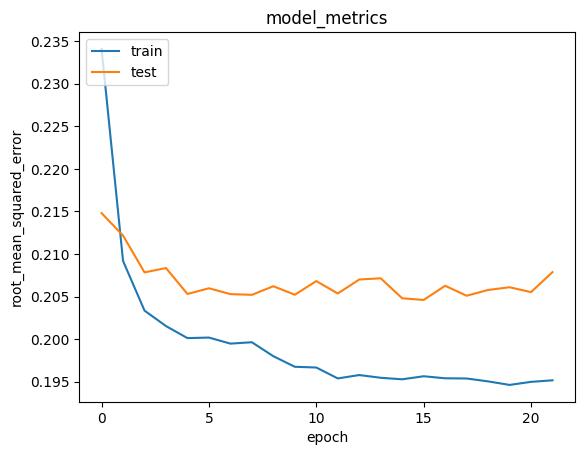

In [79]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dari visualisasi proses training model di atas model berhenti di epochs sekitar 20. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.195 dan error pada data validasi sebesar 0.207.

4.Mendapatkan Rekomendasi movie





In [80]:
movie_df = movie_new
df = pd.read_csv('movie-recommendation-data/ml-latest-small/ratings.csv')


user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]


movie_not_watched = movie_df[~movie_df['id'].isin(movie_watched_by_user.movieId.values)]['id']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

5.Untuk memperoleh rekomendasi movies, gunakan fungsi model.predict() dari library Keras dengan menerapkan kode berikut.

In [93]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing movie recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with highest ratings from user')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_name, ':', row.genre)

print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)

recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_name, ':', row.genre)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Showing movie recommendations for users: 525
Movie with highest ratings from user
--------------------------------
Ferris Bueller's Day Off (1986) : Comedy
Dogma (1999) : Adventure|Comedy|Fantasy
Virgin Suicides, The (1999) : Drama|Romance
--------------------------------
Top 10 movie recommendation
--------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Ran (1985) : Drama|War
Godfather: Part II, The (1974) : Crime|Drama
Amadeus (1984) : Drama
Cool Hand Luke (1967) : Drama


dari hasi di atas movie yang bergenre **comedy** menjadi movie yang paling tinggi ratingnya yang direkomendasikan untuk user 525. Kemudian top 10 movie yang direkomendasikan sistem adalah movie dengan genre comedy dan drama.